# Probabilistic Programming - 2: Mixture modeling

## Monte Carlo sampling

In this notebook, we are exploring a more complex problem set, namely mixture modeling. It will show you how to extend the sampling procedure to the multivariate case.

### Preliminaries

- Goal 
  - Write a Monte Carlo sampling procedure for a 2-dimensional mixture model.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - Tutorials using [Turing.jl](https://turing.ml/dev/tutorials/0-introduction/)
    - Cheatsheets: [how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

In [1]:
# Package managing
# using Pkg
# Pkg.activate("workspace")
# Pkg.instantiate()

using Logging; disable_logging(LogLevel(0))
using Distributions
using StatsPlots
using LaTeXStrings

## Data generation

We generate samples from three 2-dimensional Gaussian distributions and mix these. These Gaussians are:

$$
\begin{align*}
\mathcal{N}_1(\begin{bmatrix}-2, -2 \end{bmatrix}, \begin{bmatrix}1 & 0 \\0 & 3 \end{bmatrix}) \, , \quad
\mathcal{N}_2(\begin{bmatrix}+2, +2 \end{bmatrix}, \begin{bmatrix}3 & 0 \\0 & 1 \end{bmatrix}) \, , \quad
\mathcal{N}_3(\begin{bmatrix}-2, +2 \end{bmatrix}, \begin{bmatrix}1 & 0 \\0 & 1 \end{bmatrix}) \, .
\end{align*}
$$

We draw $N_1$, $N_2$ and $N_3$ samples from each, respectively.

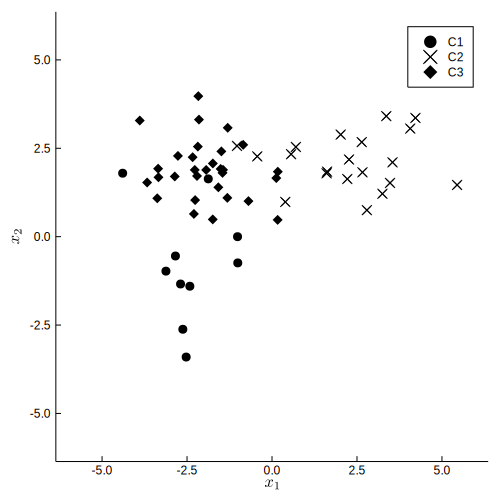

In [2]:
# Sample size
N = [10, 20, 30]

# Parameters for each cluster
μ1 = [-2. -2.]
Σ1 = [1.0 0.0; 0.0 3.0]
μ2 = [+2. +2.]
Σ2 = [3.0 0.0; 0.0 1.0]
μ3 = [-2. +2.]
Σ3 = [1.0 0.0; 0.0 1.0]

function generate_data(means::Array{Float64,2}, covariances::Array{Float64,3}; num_samples::Array{Int64,1}=[10])
    "Generate data from a 2-dimensional mixture model"
    
    # Extract number of components
    K = length(num_samples)
    
    # Extract dimensionality
    D = size(covariances)[1]
    
    # Preallocate vectors
    X = zeros(sum(num_samples), D)
    C = zeros(sum(num_samples),)
    
    # Create sample index
    ix = cat(0, cumsum(num_samples), dims=1)
    
    for k = 1:K
        
        # Current indices
        ix_k = (ix[k]+1:ix[k+1])
    
        # Sample from cluster component
        X[ix_k, :] = rand(MvNormal(means[k,:], covariances[:,:,k]), num_samples[k])'
        
        # Store cluster origin
        C[ix_k,] = k*ones(num_samples[k])
        
    end
    
    return X, C
end

# Generate data
observations, cluster = generate_data(cat(μ1, μ2, μ3, dims=1), cat(Σ1, Σ2, Σ3, dims=3), num_samples=N)

# Visualization
scatter(observations[cluster .== 1, 1], observations[cluster .== 1, 2], marker=:circle, color="black", label="C1")
scatter!(observations[cluster .== 2, 1], observations[cluster .== 2, 2], marker=:xcross, color="black", label="C2")
scatter!(observations[cluster .== 3, 1], observations[cluster .== 3, 2], 
         marker=:diamond,
         color="black", 
         label="C3", 
         xlabel=L"$x_1$", 
         ylabel=L"$x_2$", 
         xlim=[-6, 6], 
         ylim=[-6, 6], 
         size=(500,500),
         grid=false)

### Model Specification

Let's quickly recap the $K$-component Gaussian mixture model. 

We have a data set of $X$ of $N$ samples by $D$ features. Each component is a Gaussian distribution, $ p_k(x \mid \mu_k, \Sigma_k) \triangleq \mathcal{N}(x \mid \mu_k, \Sigma_k)$. In total, we model $N$ samples:

$$ p(X \mid z, \mu, \Sigma) = \sum_{i=1}^{N} \sum_{k=1}^{K} p_k(x_i \mid \mu_k, \Sigma_k)^{z_i=k} \, .$$

<!-- Note that we summarize parameters as follows: $\phi = (\phi_1, \dots, \phi_K), \mu = (\mu_1, \dots, \mu_K), \Sigma = (\Sigma_1, \dots, \Sigma_K)$.  -->
The variable $z_i$ is the assignment of sample $i$ to class $k$. The probability $p(z_{i} = k)$ is also called the _responsibility_ of component $k$ for the $i$-th sample. All $z_i$ follow a Categorical distribution with mixture weights as parameters:

$$ p(z_i) \sim \text{Cat}(\phi) \, ,$$

Being Bayesians, we put priors on all unknown parameters ($\phi, \mu, \Sigma$):

$$ \begin{align}
p(\phi) \sim&\ \text{Dir}(a_0) \\
p(\mu) \sim&\ \mathcal{N}(m_0, l_0^{-1}\Sigma) \\
p(\Sigma) \sim&\ \mathcal{W}(W_0, v_0) \end{align} \, .$$

The distribution for the mixture weights, $p(\phi)$, follows a Dirichlet distribution because it is a vector that should sum to one. The component parameter priors are a Wishart distribution for the covariance matrix and a Gaussian distribution for the mean, conditioned on the sampled covariance matrix. Together, these two priors form a [Normal-Inverse-Wishart distribution](https://en.wikipedia.org/wiki/Normal-inverse-Wishart_distribution), $p(\mu, \Sigma)$, which is the conjugate prior for the Gaussian components. The full joint distribution is therefore:

$$ \begin{align} p(X, z, \phi, \mu, \Sigma) =&\ p(X \mid z, \phi, \mu, \Sigma) p(z \mid \phi) p(\mu, \Sigma) p(\phi) \\
=&\ \sum_{i=1}^{N} \sum_{k=1}^{K} \mathcal{N}(x_i \mid \mu_k, \Sigma_k)^{z_i=k}\ \text{Cat}(z_i=k \mid \phi_k)\ \mathcal{NIW}(\mu_k, \Sigma_k \mid m_{0k}, l_{0k}, W_{0k}, v_{0k})\ \text{Dir}(\phi_k \mid a_{0k}) \end{align}$$

We are interested in the posterior distribution over $z$, which assigns the current samples to clusters via $\arg \max_{k} p(z_i = k)$. For example, if the posterior distribution for $z_i$ is $[0.32\ 0.21\ 0.47]$, then $\hat{k}_i$ is 3 and we say that $x_i$ belongs to the component 3. We are also interested in the posterior distributions for the component parameters, because these allow us to assign future samples to the current clusters. The posterior for $z, \phi, \mu, \Sigma$ has the form:

$$p(z, \phi, \mu, \Sigma \mid X) = \frac{p(z, \phi, \mu, \Sigma \mid X)}{\int p(X, z, \phi, \mu, \Sigma)\ \mathrm{d}X} \, .$$

We cannot evaluate the integral in the denominator, but because it only serves as a normalization factor we have a workaround. Note that the numerator is the full joint distribution and that if you fix the parameters $\phi, \mu, \Sigma$ to certain values, it simplifies to:

$$p(z_i \mid X) = \sum_{i=1}^{N} \sum_{k=1}^{K} \rho_k^{z_i = k} \, ,$$

where $\rho_k = \phi_k \mathcal{N}(x_i \mid \mu_k, \Sigma_k)$ for all $k$. This is a Categorical distribution! The only problem is that $\rho$ is not normalized correctly. But we know that it _should_ be correctly normalized, after division by the denominator term above, $\int p(X, z, \phi, \mu, \Sigma) \ \mathrm{d}X$. We can therefore perform the following re-parameterization:

$$r_k = \frac{\rho_k}{\sum_{k} \rho_k} \, .$$

Now, $r_k$ are valid responsibilities for the assignment variable $z$. In other words, $p(z_i \mid X) \sim \text{Cat}(r_k)$. But how should we fix $\phi, \mu, \Sigma$? <br>
Note that if we fix $z_i$ to $k=2$ for instance, the full posterior simplifies to:

$$p(\phi_2, \mu_2, \Sigma_2 \mid X) = \sum_{i=1}^{N} \mathcal{N}(x_i \mid \mu_2, \Sigma_2) \ \text{Cat}(z_i=2 \mid \phi_2)\ \mathcal{NIW}(\mu_2, \Sigma_2 \mid m_{02}, l_{02}, W_{02}, v_{02}) \ \text{Dir}(\phi_2 \mid a_{02}) \, .$$

This can be split according to $p(\phi) p(\mu, \Sigma)$:

$$\begin{align} 
p(\phi_k \mid z) =&\ \sum_{i=1}^{N} \text{Cat}(z_i \mid \phi_k)\ \text{Dir}(\phi_k \mid a_{0}) \\ 
p(\mu_k, \Sigma_k \mid X) =&\ \sum_{i=1}^{N} \mathcal{N}(x_i \mid \mu_k, \Sigma_k)\ \mathcal{NIW}(\mu_k, \Sigma_k \mid m_{0k}, l_{0k}, W_{0k}, v_{0k}) 
\end{align}$$

which are Dirichlet and a Normal-Inverse-Wishart distributions. So, we have multiple marginal posteriors with known forms. This is ideal for Gibbs sampling: first, we draw cluster assignments from a Categorical distribution based on the current posteriors of the parameters and then, we draw mixture weights and Gassian component parameters given the posterior distributions for the cluster assignments.

In [3]:
using Turing
using MCMCChains
Turing.setadbackend(:forward_diff)
include("../scripts/pp-2.jl");

Let's start simple and slowly increase the complexity of the model.

### Model 1: means only

We will assume K=2 classes, equal class proportions, $\phi = [0.5 \ 0.5]$, and spherical covariance matrices, $\Sigma_k = \mathcal{I}$ for all $k$. Using these assumptions, we estimate the means $\mu$ and compute the posterior of $z$.

In [4]:
@model GaussianMixtureModel(X, m1, m2) = begin
    "2-dimensional Gaussian mixture model with spherical covariances"
    
    # Data shape
    N, D = size(X)

    # Draw the mean for cluster 1 [2x1 vector]
    μ1 ~ MvNormal(m1, 10*[1. 0.; 0. 1.])
    
    # Draw the mean for cluster 2 [2x1 vector]
    μ2 ~ MvNormal(m2, 10*[1. 0; 0. 1.])
    
    # Concatenate means [2x2 matrix]
    μ = [μ1 μ2]
    
    # Probability of belonging to each cluster [2x1 vector]
    ϕ = [0.5, 0.5]
    
    # Preallocate assignment vector [Nx1 vector]
    z = Vector{Int}(undef, N)
    
    # Loop over observations
    for i in 1:N
        
        # Draw assignment for i-th sample from a Categorical distribution parameterized by ϕ
        z[i] ~ Categorical(ϕ)
        
        # Data point x[i] follows a normal distribution, with mean indexed by the assignment variable z[i]
        X[i,:] ~ MvNormal(μ[:, z[i]], [1. 0; 0. 1.])
    end
    
    # Return the assignments
    return z
end

# Set priors
m1 = [-2, -2]
m2 = [+2, +2]

# Create an instance of a model, using the observations
model = GaussianMixtureModel(observations, m1, m2);

Well construct a Gibbs sampler, partly sampling the cluster assignment $z$ and partly the means.

In [5]:
# Length of chain
len_chain = 200

# Construct Gibbs sampler
sampler = Gibbs(PG(20, :z), HMC(0.1, 2, :μ1, :μ2))

# Start sampling
chain = sample(model, sampler, len_chain);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


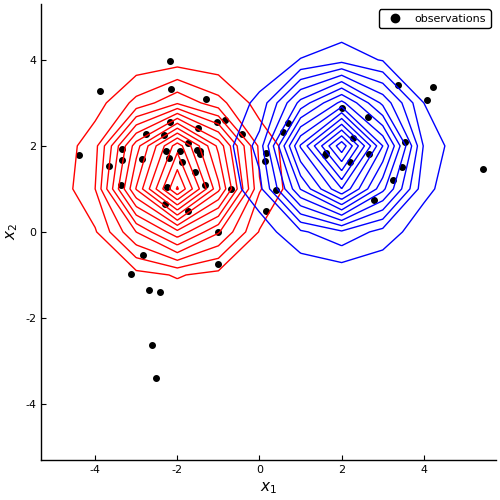

In [6]:
# Extract the means over the MCMC chains
μ1_hat = mean_chain(chain, :μ1)
μ2_hat = mean_chain(chain, :μ2)

# Plot data and overlay estimated posterior probabilities
plot_posteriors(observations, μ1_hat, μ2_hat, x1=range(-5, stop=5), x2=range(-5, stop=5))

Let's take a closer look at the chain. 

In [7]:
describe(chain[[:μ1, :μ2]])

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std      │ naive_se  │ mcse      │ ess     │
│     │ Symbol     │ Float64  │ Float64  │ Float64   │ Float64   │ Any     │
├─────┼────────────┼──────────┼──────────┼───────────┼───────────┼─────────┤
│ 1   │ μ1[1]      │ -1.98805 │ 0.300151 │ 0.0212239 │ 0.0936805 │ 7.09726 │
│ 2   │ μ1[2]      │ 1.31618  │ 0.251094 │ 0.017755  │ 0.0690124 │ 10.9588 │
│ 3   │ μ2[1]      │ 1.94179  │ 0.663452 │ 0.0469132 │ 0.358442  │ 3.84963 │
│ 4   │ μ2[2]      │ 1.86004  │ 0.324754 │ 0.0229636 │ 0.219076  │ 2.43755 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 1   │ μ1[1]      │ -2.39936 │ -2.17841 │ -2.04652 │ -1.87881 │ -1.25273 │
│ 2   │ μ1[2]      │ 0.883976 │ 1.18098  │ 1.27805  │ 1.438

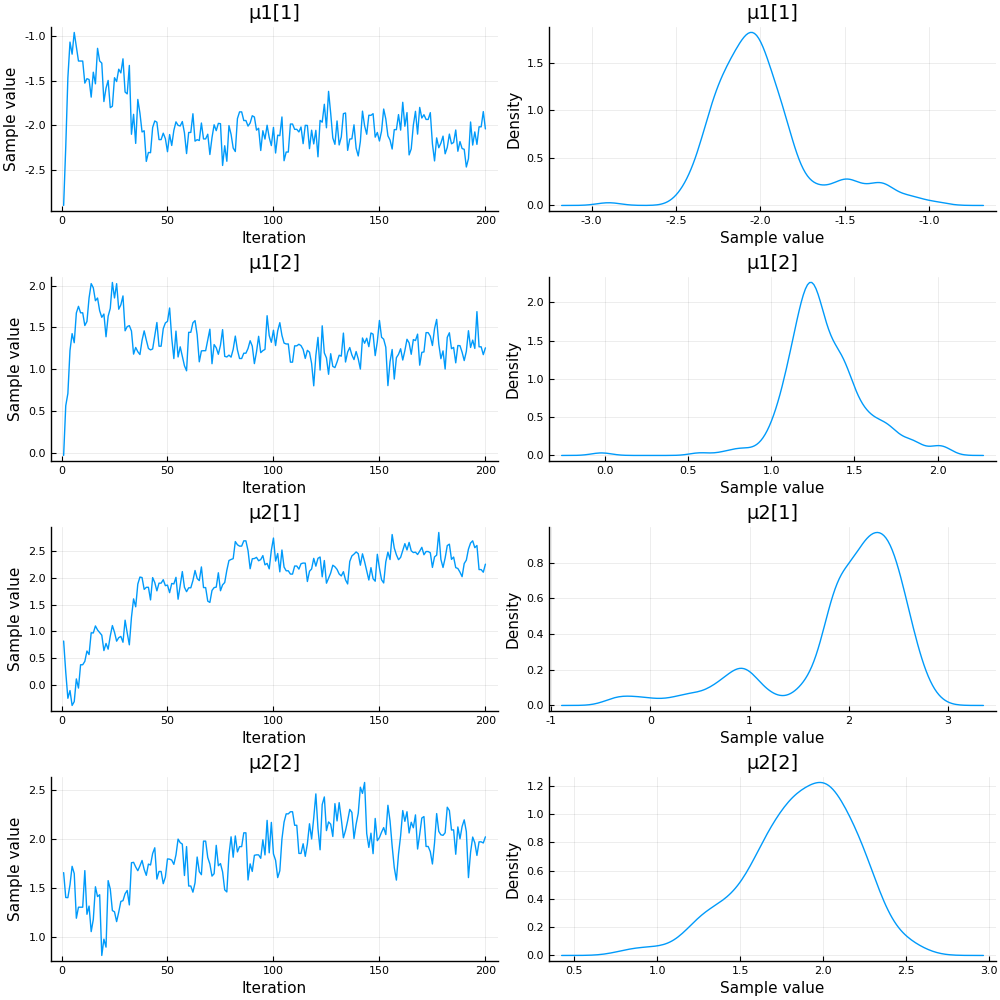

In [8]:
plot(chain[[:μ1, :μ2]])

### Model 2: means and covariances

We modeled the data with spherical Gaussians. But the data doesn't really look spherical; the cluster plot showed that quite a few samples are not covered by the two Gaussians. This suggests that we should estimate the covariance matrices as well. 

A variance parameter is a strictly positive number and is captured with a Gamma distrbution. A covariance matrix is a positive-definite matrix and can be captured with a Wishart distribution. The [Wishart distribution](https://en.wikipedia.org/wiki/Wishart_distribution) is the natural multivariate extension of the Gamma distribution:

$$ \mathcal{W}_p(C \mid V, n) = \frac{1}{2^{np/2} \ |V|^{n/2} \ \Gamma_p(n/2)} |C|^{(n-p-1)/2} \exp(-\text{tr}(V^{-1}C)/2)$$

where $p$ is the dimensionality of the matrix-variate, $n$ is the degrees of freedom and $V$ is a scale matrix. $\Gamma_p$ is a multivariate gamma function (continuous version of the factorial function).

It is relatively straightforward to add two Wishart priors to the model:

In [9]:
@model GaussianMixtureModel(X, m1, m2, S1, S2) = begin
    "2-dimensional Gaussian mixture model with free covariances"
    
    # Data shape
    N, D = size(X)
    
    # Draw a covariance matrix for each cluster [2x2 matrix]
    Σ1 ~ Wishart(2, S1)
    Σ2 ~ Wishart(2, S2)
    
    # Draw means for each cluster [2x1 vector]
    μ1 ~ MvNormal(m1, Σ1)
    μ2 ~ MvNormal(m2, Σ2)
    
    # Concatenate parameters to allow for indexing
    μ = [μ1 μ2]
    Σ = cat(Σ1, Σ2, dims=3)
    
    # Probability of belonging to each cluster [2x1 vector]
    ϕ = [0.5, 0.5]
    
    # Preallocate assignment vector [Nx1 vector]
    z = Vector{Int}(undef, N)
    
    # Loop over observations
    for i in 1:N
        
        # Draw assignment for i-th sample from a Categorical distribution parameterized by ϕ
        z[i] ~ Categorical(ϕ)
        
        # Data point x[i] follows a normal distribution, with mean and covariance indexed by z[i]
        X[i,:] ~ MvNormal(μ[:, z[i]], Σ[:,:, z[i]])
    end
    
    # Return the assignments
    return z
end

# Set prior means
m1 = [-1, -1]
m2 = [+1, +1]

# Set prior covariances
S1 = [1. 0.;0. 1.]
S2 = [1. 0.;0. 1.]

# Create an instance of a model, using the observations
model = GaussianMixtureModel(observations, m1, m2, S1, S2);

We'll have to extend the sampler as well. For now, we'll include $\Sigma1$ and $\Sigma2$ in the Hamiltonian MC procedure.

In [10]:
# Construct Gibbs sampler
sampler = Gibbs(PG(20, :z), HMC(0.1, 2, :μ1, :μ2, :Σ1, :Σ2))

# Start sampling
chain = sample(model, sampler, 500);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:18


Let's extract the sample averages for the means and covariances of the clusters.

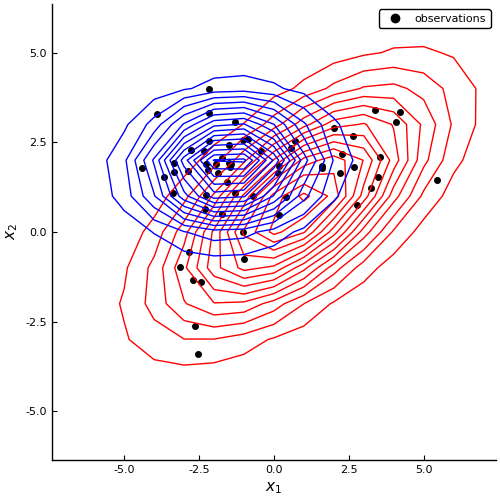

In [11]:
# Extract the means over the MCMC chains
μ1_hat = mean_chain(chain, :μ1)
μ2_hat = mean_chain(chain, :μ2)
Σ1_hat = reshape(mean_chain(chain, :Σ1), (2,2))
Σ2_hat = reshape(mean_chain(chain, :Σ2), (2,2))

# Plot data and overlay estimated posterior probabilities
plot_posteriors(observations, μ1_hat, μ2_hat, Σ1=Σ1_hat, Σ2=Σ2_hat, x1=range(-7, stop=7), x2=range(-6, stop=6))

Notice that we've improved coverage of all the points, but the fit is still not perfect.

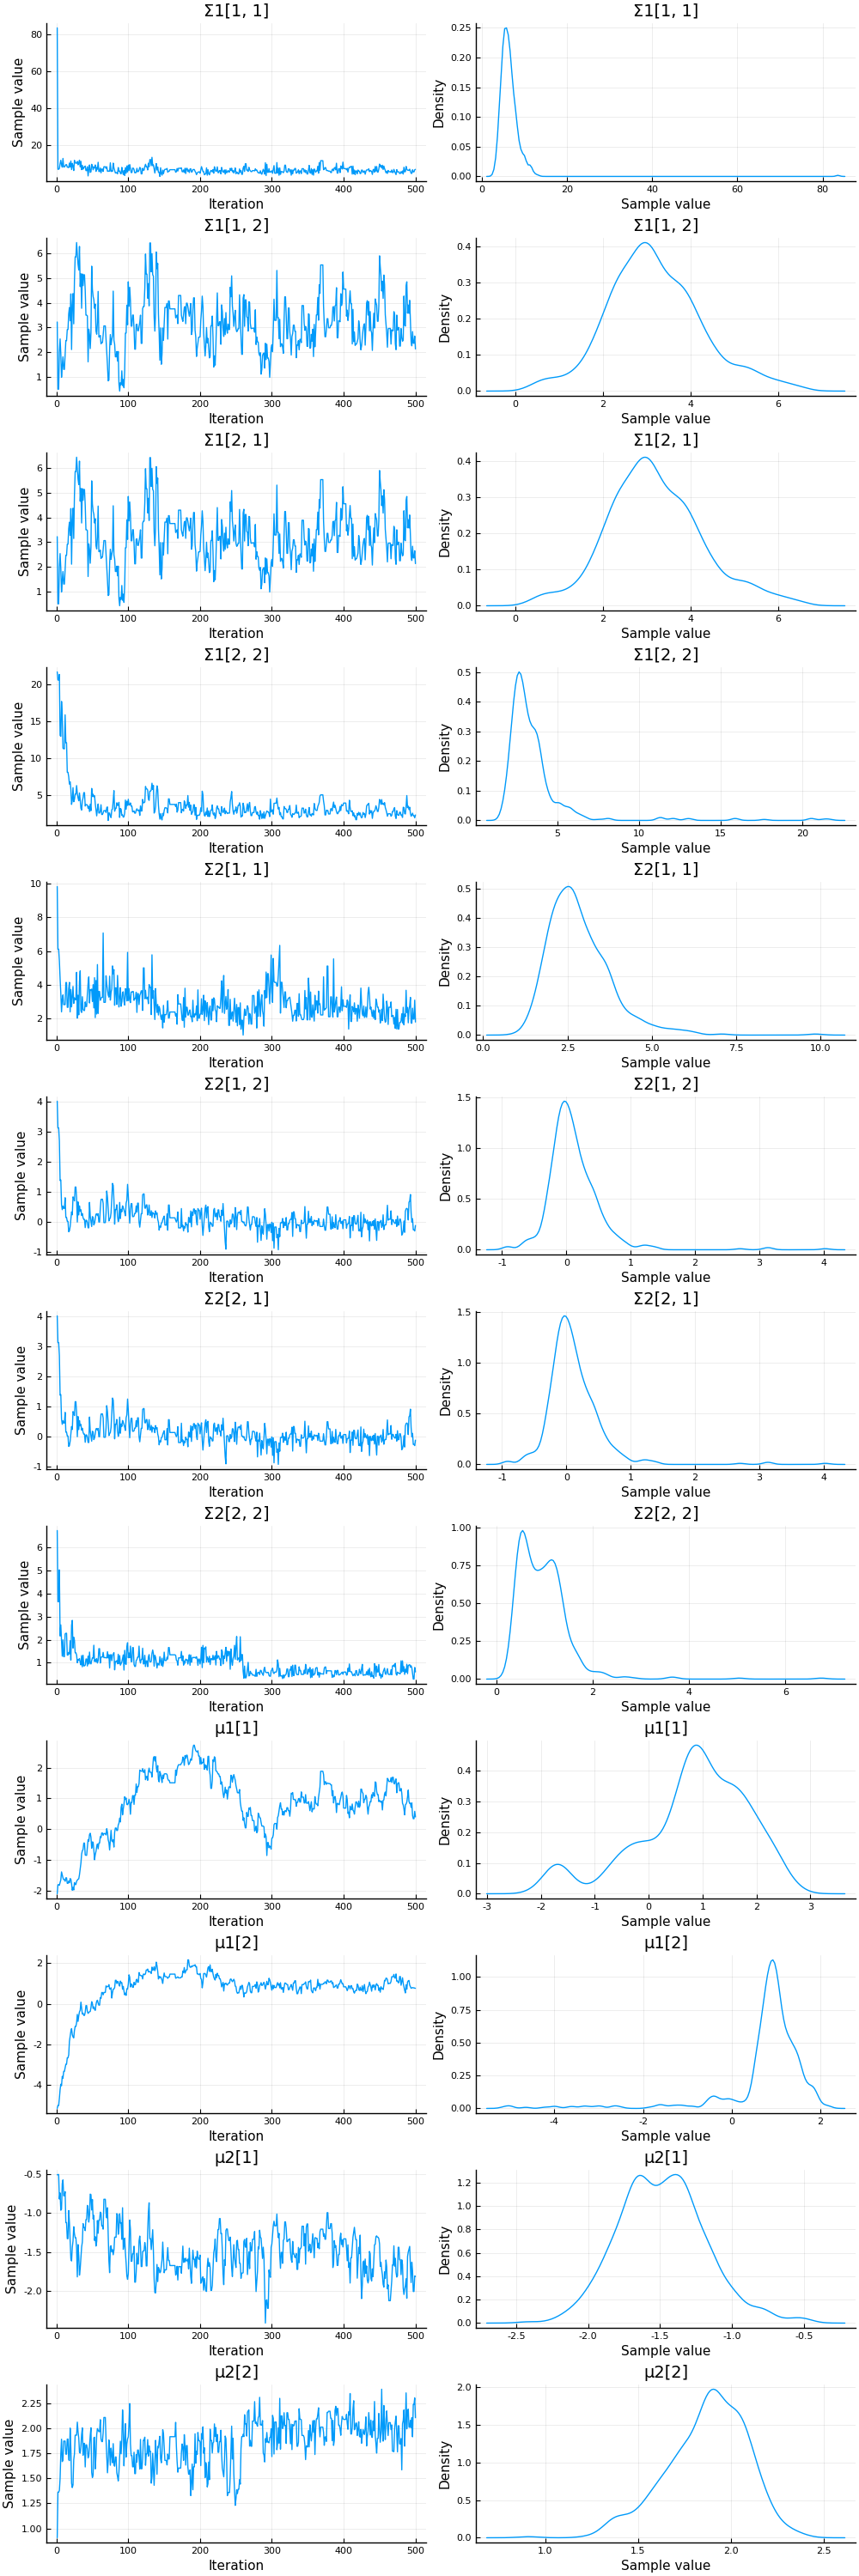

In [12]:
plot(chain[[:μ1, :Σ1, :μ2, :Σ2]])

### Model 3: means, covariances, mixture weights

In [13]:
@model GaussianMixtureModel(X, m1, m2, S1, S2, a) = begin
    "2-dimensional Gaussian mixture model with free covariances"
    
    # Data shape
    N, D = size(X)
    
    # Draw a covariance matrix for each cluster [2x2 matrix]
    Σ1 ~ Wishart(2, S1)
    Σ2 ~ Wishart(2, S2)
    
    # Draw means for each cluster [2x1 vector]
    μ1 ~ MvNormal(m1, Σ1)
    μ2 ~ MvNormal(m2, Σ2)
    
    # Draw a proportion 
    ϕ ~ Dirichlet(a)
    
    # Concatenate parameters to allow for indexing
    μ = [μ1 μ2]
    Σ = cat(Σ1, Σ2, dims=3)
    
    # Preallocate assignment vector [Nx1 vector]
    z = Vector{Int}(undef, N)
    
    # Loop over observations
    for i in 1:N
        
        # Draw assignment for i-th sample from a Categorical distribution parameterized by ϕ
        z[i] ~ Categorical(ϕ)
        
        # Data point x[i] follows a normal distribution, with mean and covariance indexed by z[i]
        X[i,:] ~ MvNormal(μ[:, z[i]], Σ[:,:, z[i]])
    end
    
    # Return the assignments
    return z
end

# Set prior means
m1 = [-1, -1]
m2 = [+1, +1]

# Set prior covariances
S1 = [1. 0.;0. 1.]
S2 = [1. 0.;0. 1.]

# Set prior proportions
a = [1., 1.]

# Create an instance of a model, using the observations
model = GaussianMixtureModel(observations, m1, m2, S1, S2, a);

We expand the sampler, again contrasting the cluster assignments with the model parameters. 

In [14]:
# Construct Gibbs sampler
sampler = Gibbs(PG(20, :z), HMC(0.1, 2, :μ1, :μ2, :Σ1, :Σ2, :ϕ))

# Start sampling
chain = sample(model, sampler, 500);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:16


Extract parameters from the chains.

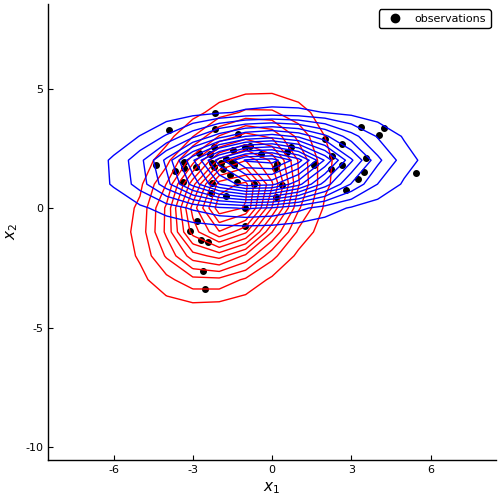

In [15]:
# Extract the means over the MCMC chains
ϕ_hat = mean_chain(chain, :ϕ)
μ1_hat = mean_chain(chain, :μ1)
μ2_hat = mean_chain(chain, :μ2)
Σ1_hat = reshape(mean_chain(chain, :Σ1), (2,2))
Σ2_hat = reshape(mean_chain(chain, :Σ2), (2,2))

# Plot data and overlay estimated posterior probabilities
plot_posteriors(observations, μ1_hat, μ2_hat, Σ1=Σ1_hat, Σ2=Σ2_hat, ϕ=ϕ_hat, x1=range(-8, stop=8), x2=range(-10, stop=8))

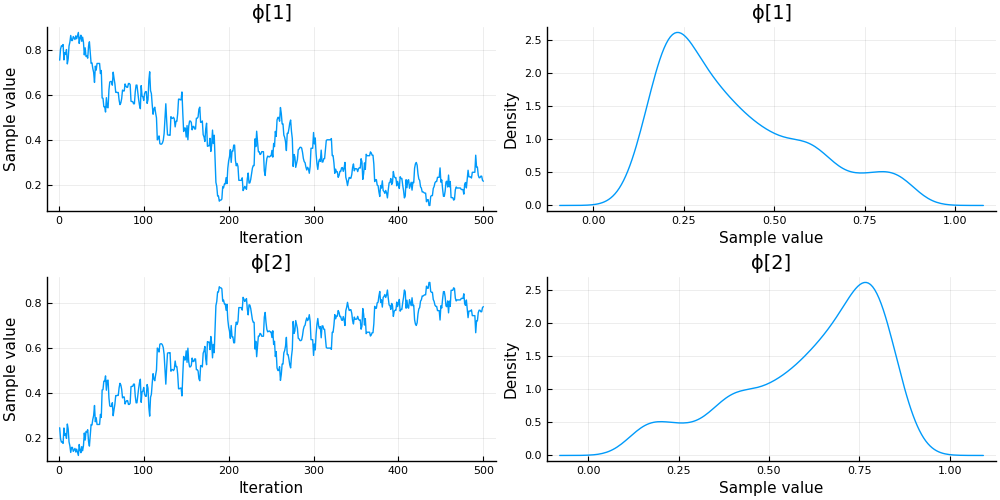

In [16]:
plot(chain[:ϕ])

### Assignment 1: 3 clusters

Can you change the model to work with 3 clusters instead of 2?

### Optional Assignment: Dirichlet Process

Are we sure we need 3 clusters to model this data? Maybe we need 4? Or 5? 

There is a way to automatically determine the number of clusters in the data. It's called a [Dirichlet Process](https://en.wikipedia.org/wiki/Dirichlet_process). It treats the number of components as a random variable that still needs to be estimated. See if you can implement from just the Wikipedia description of the model. If you get stuck, you can have a look at the Turing.jl tutorial ["Infinite mixture models"](https://turing.ml/dev/tutorials/6-infinitemixturemodel/).